<a href="https://colab.research.google.com/github/flosch9/deep_learning_home_exam/blob/main/Task_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive for loading data

In [73]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 22 21:02:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0              29W /  70W |   2253MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Define and load model (model.py)

```
# Als Code formatiert
```



In [75]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights


class FCN32(nn.Module):
    def __init__(self, output_size = (128,128), num_classes = 2,
                 small_vgg = False, pre_trained = True, dropout = False):
        super(FCN32, self).__init__()

        self.dropout = dropout

        # first part is regualr vgg16 (without batch normalization)?
        if pre_trained:
          w = VGG16_Weights.IMAGENET1K_V1
        else:
          w = None

        if small_vgg:
          self.features = vgg16(weights = w).features[0:28]
        else:
          self.features = vgg16(weights = w).features

        # classifier is now replaced with another cnn (instead of a fc)
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            # 512 output from last cnn/maxpool layer #maybe only 1000 channels
            # use filter size 1024 or 4096
            nn.ReLU(True),
            #with Relu? with Batchnorm? with maxpool?
            # 7x7 filter
            nn.Conv2d(4096, num_classes, kernel_size=1, stride=(1,1), padding=(1,1))
            #nn.Softmax()
            #softmax produces niceer output in the end
            # makes difference in the output, and in the loss which (none) activation is used
        )

        self.classifier_with_dropout = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=(3,3), stride=(1,1), padding=(1,1)), # 512 output from last cnn/maxpool layer #maybe only 1000 channels
            # use filter size 1024 or 4096
            nn.Dropout(p = 0.5),
            nn.ReLU(True),
            #with Relu? with Batchnorm? with maxpool?
            # 7x7 filter
            nn.Conv2d(4096, num_classes, kernel_size=1, stride=(1,1), padding=(1,1)),
            nn.Dropout(p = 0.5)
            #nn.Softmax()
            #softmax produces niceer output in the end
            # makes difference in the output, and in the loss which (none) activation is used

        )

        self.upsample = nn.Sequential(
            # what is with upsampling meant? this (just resizing) or the deconvolution before upsample and transposeconv2d the same???
            # this one is not trainable but easier
            nn.UpsamplingBilinear2d(size=(output_size))
            #nn.Softmax() use the nn.Softmax at end for output

            #nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=0)#, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)
            # then output needs to be adjusted and classes in one channel
            # try to set ceiling of maxpool to true
        )

    def forward(self, x):

        x = self.features(x)
        if self.dropout:
          x = self.classifier_with_dropout(x)
        else:
          x = self.classifier(x)
        x = self.upsample(x)

        return x



# Define train and test functions (traintestfuncs.py)

In [116]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import PILToTensor, ToTensor, ToPILImage, Resize
from torchvision.utils import make_grid

# not needed in notebook
#from model import FCN32


def smallerDataset(dataset, size):

    smaller_dataset = []

    for i in range(size):
        smaller_dataset.append(dataset[i])

    return(smaller_dataset)


# since the dataloader can t handle the PIL Image class of the original dataset
# for each batch the lables and images have to be stacked to a tensor manually
# in this step also the PIL Images are transformed to a tensor
# do not use ToTensor for target image since it destroys the class

def customCollate(batch, resize, device):

    images = []
    labels_orig = []
    labels_merched = []

    for dataset in batch:
        """
        image = ToTensor()(dataset[0])

        label = PILToTensor()(dataset[1]) # important else target fckd up with classes
        label = label.view(resize) #to get rid of the (implizit) given channel

        label = label.long() # also importantz for CE-Loss, excpects long
        #print(torch.unique(label))
        # merching classes background and border
        label_merched = torch.where(label == 3, 1, label)
        #print(torch.unique(label))
        label_merched = torch.sub(label_merched, 1) # also important since 3 classes -> [0,3), but original it was [1,3]
        #print(torch.unique(label_merched))
        label_orig = torch.sub(label, 1)
        #print(torch.unique(label_orig))
        """
        image, label_merched, label_orig = singleCollate(dataset, resize, device)

        images.append(image)
        labels_merched.append(label_merched)
        labels_orig.append(label_orig)

    return(torch.stack(images).to(device),
           torch.stack(labels_merched).to(device),
           torch.stack(labels_orig).to(device))


def singleCollate(batch, resize, device):

    image = ToTensor()(batch[0])

    label = PILToTensor()(batch[1]) # important else target fckd up with classes
    label = label.view(resize) #to get rid of the (implizit) given channel

    label = label.long() # also importantz for CE-Loss, excpects long
    #print(torch.unique(label))
    # merching classes background and border
    label_merched = torch.where(label == 3, 1, label)
    #print(torch.unique(label))
    label_merched = torch.sub(label_merched, 1) # also important since 3 classes -> [0,3), but original it was [1,3]
    #print(torch.unique(label_merched))
    label_orig = torch.sub(label, 1)
    #print(torch.unique(label_orig))

    return(image.to(device),label_merched.to(device),
           label_orig.to(device))



def testModel(model, lossFunction, test_dataload, batch_size, show_plot = False):

  test_loss = 0
  batch_number = 0

  last_full_dataset = []

  model.eval()

  for i, dataset in enumerate(test_dataload):

        # unpack images and labels of batch
        images , labels, labels_orig = dataset

        output = model(images)

        # compute loss
        loss = lossFunction(output, labels)

        test_loss += loss.item()
        batch_number += 1

        with open(FOLDERPATH + "testing_loss_fine.csv", 'a') as file:
            file.write("{};\t{}\n".format(i+1, loss))

  return(test_loss/batch_number)


def trainBatch(model, lossFunction, Optimizer,
              train_dataload, test_dataload,
              NUMBEREPOCHS, FOLDERPATH):

  running_loss = 0
  batch_number = 0

  model.train()

  for i, dataset in enumerate(train_dataload):

      # unpack images and labels of batch
      images , labels, _ = dataset

      # reset optimizer gradients
      Optimizer.zero_grad()

      # forward pass
      outputs = model(images)

      # compute loss
      loss = lossFunction(outputs, labels)

      loss.backward()
      Optimizer.step()

      running_loss += loss.item()
      batch_number += 1

      with open(FOLDERPATH + "training_loss_fine.csv", 'a') as file:
        file.write("{};\t{}\n".format(i+1, loss))

  return(running_loss, batch_number)


def trainModel(model, lossFunction, Optimizer,
              train_dataload, test_dataload,
              NUMBEREPOCHS, BATCHSIZE, FOLDERPATH):

  with open(FOLDERPATH + "training_loss_fine.csv", 'w') as file:
            file.write("Batch number; loss\n")

  with open(FOLDERPATH + "testing_loss_fine.csv", 'w') as file:
    file.write("Batch number; loss\n")

  training_loss = np.zeros(NUMBEREPOCHS)
  test_loss = np.zeros(NUMBEREPOCHS)

  for epoch in range(NUMBEREPOCHS):

    # train every batch
    running_loss, batch_number = trainBatch(model, lossFunction,
                                           Optimizer, train_dataload,
                                           test_dataload, NUMBEREPOCHS,
                                           FOLDERPATH)

    # test in each epoch
    test_loss[epoch] = testModel(model, lossFunction, test_dataload,
                                    BATCHSIZE)

    # print epoch statistics
    training_loss[epoch] = running_loss / batch_number

    print("\nEpoch [{}/{}]".format(epoch+1,NUMBEREPOCHS))
    print("{} updates in this epoch.".format(batch_number))
    print("Trainingloss: {}".format(training_loss[epoch]))
    print("Testingloss: {}".format(test_loss[epoch]))

  torch.save(model.state_dict(), FOLDERPATH + "model_v" + VERSION)
  print("\nTrained model parameters saved in {}.".format(FOLDERPATH))

  return(training_loss, test_loss)


def plotLosses(training_loss, test_loss, FOLDERPATH):

  x = np.linspace(1,len(training_loss), num=len(training_loss))

  plt.plot(x, training_loss, '.', label = "training")
  plt.plot(x, test_loss, '.', label = "testing")
  plt.grid()
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc = "best")
  plt.savefig(FOLDERPATH + "losses_during_training.png")

  return()


def selectClass(raw_output):

  # use softmax here or after last layer?
  output = nn.Softmax(dim=1)(raw_output)

  class_output = torch.where(output[:,1,:,:] >= output[:,0,:,:], 1.0 , 0.0)
  class_output = class_output.view([output.shape[0], 1, output.shape[2],
                     output.shape[3]])

  """
  threshold = 0.5 #change / play around here?

  #print(torch.unique(output[0,0,:,:]))# values between 0 and 1
  #print(torch.unique(output[0,1,:,:]))

  # print(tmp.shape)
  # selecting class (or take max?)
  class_output = torch.where(output[:,0,:,:] > threshold, 0.0 , 1.0)
  class_output = class_output.view([output.shape[0], 1, output.shape[2],
                     output.shape[3]])

  # with color then transitions better shown?
  #tmp[:,0,:,:] = output[:,0,:,:]
  #tmp[:,1,:,:] = output[:,1,:,:]
  """


  return(class_output)


def visualizeOutputs(model, test_data, resize, device, FOLDERPATH):

  model.eval()

  # for making plot
  datasize = len(test_data)
  stop = datasize-16
  i = torch.randint(0, stop, (1,)).item()

  sub_set = [test_data.__getitem__(j) for j in range(i,i+16)]

  test_images, test_labels, labels_orig = customCollate(sub_set, resize, device)

  output = model(test_images)

  # recover explizit color channel for plotting
  test_labels = test_labels.view(test_labels.shape[0], 1,
                                 test_labels.shape[1], test_labels.shape[2])

  # assign raw output to a class
  output = selectClass(output)

  grid_1 = ToPILImage()(make_grid(test_images, nrow = int(len(test_images)/4)))
  grid_2 = ToPILImage()(make_grid(test_labels.float(),
                                  nrow = int(len(test_labels)/4)))
  grid_3 = ToPILImage()(make_grid(output, nrow = int(len(output)/4)))

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize =(10,6))
  ax[0].imshow(grid_1)
  ax[0].set_title("Input")
  ax[0].axis("off")
  ax[1].imshow(grid_2, cmap = "gray")
  ax[1].set_title("Labels (border and background merged)")
  ax[1].axis("off")
  ax[2].imshow(grid_3, cmap = "gray")
  ax[2].set_title("Prediction")
  ax[2].axis("off")
  fig.tight_layout()
  plt.savefig(FOLDERPATH + "output_visualisation.png")

  return()

def evaluateFCN(model, test_data, resize, device, FOLDERPATH):

  model.eval()

  with open(FOLDERPATH + "evaluation.csv", 'w') as file:
    file.write("Mean accuracy; IOU; Mean accuarcy (without border); IOU (without border)\n")

  datasize = len(test_data)

  all_pixels = resize[0] * resize[1]

  running_whole_mean_acc = 0
  running_whole_iou = 0
  running_part_mean_acc = 0
  running_part_iou = 0

  # loopin gover batchsize from dataloader also possible
  with torch.no_grad():
    for i in range(datasize):

          data_pair = test_data.__getitem__(i)

          image, label, label_orig = singleCollate(data_pair, resize, device)
          #needed for input in model
          image = image.view(1, image.shape[0], image.shape[1], image.shape[2])

          output = model(image)

          # select classes based on network output
          output = selectClass(output)

          # for binary segmentation
          # compute accuracy
          right_pixels = torch.where(output == label, 1, 0)
          accuracy = torch.sum(right_pixels)/all_pixels

          # iou
          area_label = torch.sum(label)
          area_prediction = torch.sum(output)
          intersection = torch.where(right_pixels == 1, 1,0)
          iou = torch.sum(intersection)/(area_label + area_prediction)

          running_whole_mean_acc += accuracy
          running_whole_iou += iou

          # without boundary
          boundary_pixels = torch.where(label_orig == 2, 1, 0)
          part_pixels = all_pixels - torch.sum(boundary_pixels)

          # (also on output? or just dropping this pixels on output?)
          # compute accuracy
          right_pixels = torch.where(output == label_orig, 1, 0)
          accuracy = torch.sum(right_pixels)/part_pixels

          # iou (how here boundary dropped in output?)
          orig_seg = torch.where(label_orig == 1,1,0)
          area_label = torch.sum(orig_seg)
          area_prediction = torch.sum(output)
          intersection = torch.where(right_pixels == 1, 1,0)
          iou = torch.sum(intersection)/(area_label + area_prediction)

          running_part_mean_acc += accuracy
          running_part_iou += iou

  whole_mean_acc = running_whole_mean_acc / datasize
  whole_iou = running_whole_iou / datasize
  part_mean_acc = running_part_mean_acc / datasize
  part_iou = running_part_iou / datasize

  with open(FOLDERPATH + "evaluation.csv", 'a') as file:
    file.write("{}; {}; {}; {}".format(whole_mean_acc, whole_iou,
                                       part_mean_acc, part_iou))

  # mean accuracy/ IOU whole
  print("\nAccuracy for binary segmentation: {}%".format(whole_mean_acc*100))
  print("IOU for binary segmentation: {}%".format(whole_iou*100))

  # mean accuracy/ IOU without border
  print("\nAccuracy when ignoring boundary pixels: {}%".format(part_mean_acc*100))
  print("IOU when ignoring boundary pixels: {}%".format(part_iou*100))

  return()

def createUncertaintyMap(model, test_data, resize, device,
                         FOLDERPATH, num_maps = 16, num_forward = 10):

  if not model.dropout:
    model.dropout = True

  model.eval()
  model.classifier_with_dropout.train()
  # important to enable dropout eval turns of by default

  # for making plot
  stop = len(test_data)-num_maps
  i = torch.randint(0, stop, (1,)).item()

  test_data = [test_data.__getitem__(j) for j in range(i,i+num_maps)]

  images, labels, labels_orig = customCollate(test_data, resize, device)

  datasize = len(images)

  single_predictions = torch.zeros([num_forward, num_maps, 1,
                                    images.shape[2], images.shape[3]])

  with torch.no_grad():
    for i in range(num_forward):
      #for j,image in enumerate(images):
        output = model(images)
        output = selectClass(output)
        single_predictions[i] = output

  variance = torch.var(single_predictions, dim = 0)# keepdim = True)

  mean_output = torch.mean(single_predictions, dim = 0)

  variance = variance.view(num_maps, 1, images.shape[2], images.shape[3])
  labels_orig = labels_orig.view(num_maps, 1, images.shape[2], images.shape[3])

  grid_1 = ToPILImage()(make_grid(images, nrow = int(len(images)/4)))
  grid_2 = ToPILImage()(make_grid(labels_orig.float(),
                                  nrow = int(len(output)/4), normalize = True))

  grid_3 = ToPILImage()(make_grid(mean_output.float(),
                                  nrow = int(len(output)/4), normalize = True))

  grid_4 = ToPILImage()(make_grid(variance,
                                  nrow = int(len(output)/4), normalize = True))

  # color mode for uncertainity ??
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize =(9,8))#,
                         #layout='constrained')
  ax[0,0].imshow(grid_1)
  ax[0,0].set_title("Input")
  ax[0,0].axis("off")
  ax[0,1].imshow(grid_2, cmap = "gray")
  ax[0,1].set_title("Original labels (with border)")
  ax[0,1].axis("off")
  ax[1,0].imshow(grid_3, cmap = "gray")
  ax[1,0].set_title("Predicted labels (mean)")
  ax[1,0].axis("off")
  unc = ax[1,1].imshow(grid_4, cmap = "gray", vmin = 0, vmax = 1)
  ax[1,1].set_title("Uncertainity")
  ax[1,1].axis("off")
  fig.colorbar(unc, ax=ax[1,1], cmap = "gray")#, shrink = 0.52)
  fig.tight_layout()
  plt.savefig(FOLDERPATH + "uncertainty_map.png")

  return()



# Train and evaluate model (main.py)


------------------------------------------------------------------


Found GPU!

File with trainingparameters of model saved in 
 /content/drive/MyDrive/Deep_learning_home_exam/data/problem2/FCN_v07/

------------------------------------------------------------------

Dataset loaded.

------------------------------------------------------------------

Starting training.


Epoch [1/10]
230 updates in this epoch.
Trainingloss: 0.60617632140284
Testingloss: 0.5047435041355051

Epoch [2/10]
230 updates in this epoch.
Trainingloss: 0.5049240113600441
Testingloss: 0.41398415669150973

Epoch [3/10]
230 updates in this epoch.
Trainingloss: 0.4687647503355275
Testingloss: 0.39083357725454415

Epoch [4/10]
230 updates in this epoch.
Trainingloss: 0.4412713646888733
Testingloss: 0.3616961362569229

Epoch [5/10]
230 updates in this epoch.
Trainingloss: 0.4245826037033745
Testingloss: 0.38008420674697213

Epoch [6/10]
230 updates in this epoch.
Trainingloss: 0.4092699644358262
Testingloss: 0.35311

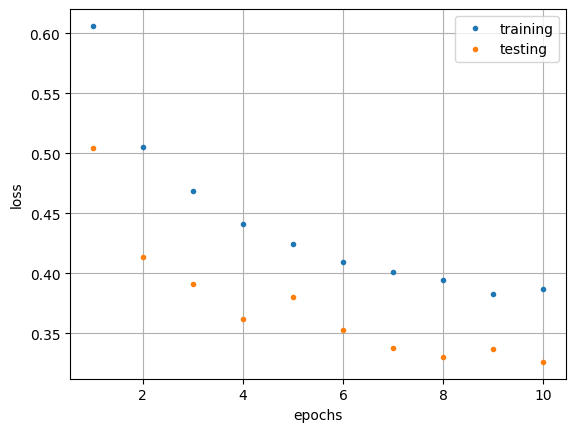

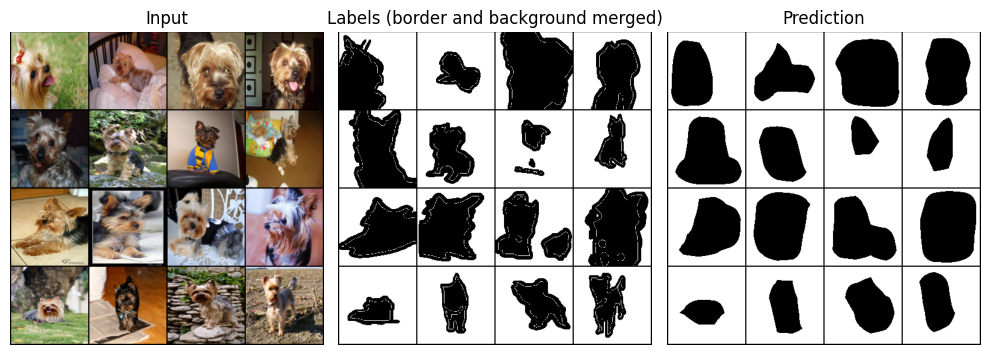

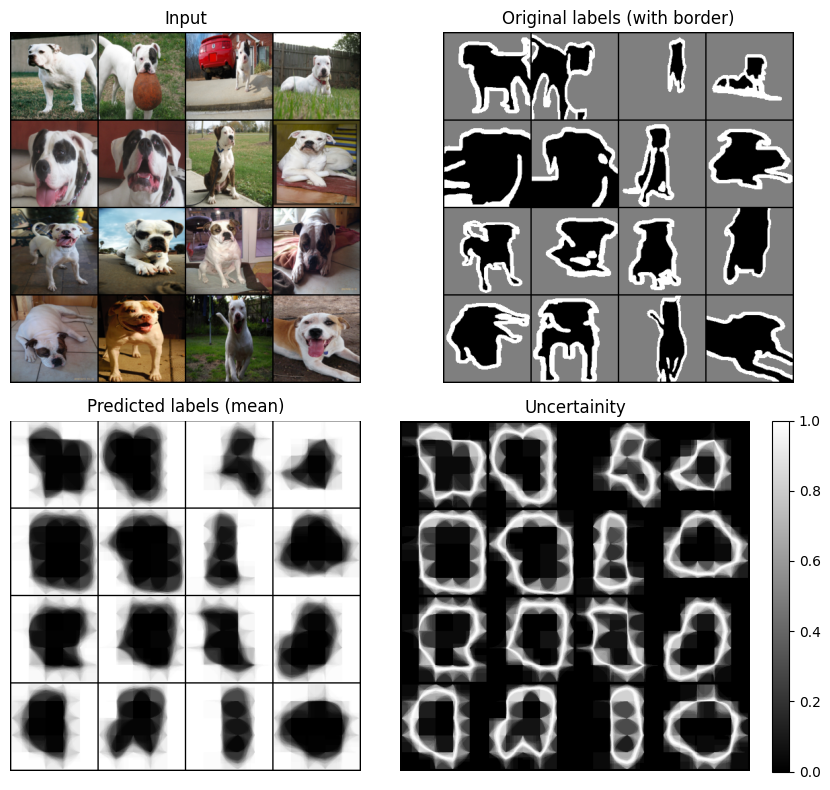

In [119]:
import os, shutil
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor, ToTensor, ToPILImage, Resize

#from torchvision.models import vgg16, VGG16_Weights

#from model import FCN32
#from traintestfuncs import *

#from test import show_output, test_model, show_uncertainity_map

###############################################################################
# general Parameters for training (make adjustments here)
###############################################################################
# Path for notebook
ROOTPATH = "/content/drive/MyDrive/Deep_learning_home_exam/data/problem2/"

# Path for local
#ROOTPATH = "home_exam\data\problem2\\"

# for saving model with trained parameters
VERSION = "08"

MODE = "train" # "train" or "evaluate"

# parameters for training (only for mode "train")
NUMBEREPOCHS = 10
BATCHSIZE = 16
LEARNINGRATE = 0.001

# resize dataset to see faster runtrough
SMALLDATASET = False
smaller_train_dataset_size = 20
smaller_test_dataset_size = 20


# resizing images of dataset so that they all have the same size
# (which they originaly dont have)
RESIZE =(128,128)


PRETRAINED = True
TRAINPRETRAINED = True
SMALLVGG = False
DROPOUT = True

model = FCN32(output_size=RESIZE, small_vgg = SMALLVGG,
              pre_trained = PRETRAINED, dropout = DROPOUT)

lossFunction = nn.CrossEntropyLoss() #nn.MSELoss()

Optimizer = optim.Adam(model.parameters(),lr = LEARNINGRATE) #optim.SGD()



print("\n------------------------------------------------------------------\n")

###############################################################################
# directory for output files for model version / loading model
###############################################################################

foldername = "FCN_v" + VERSION + "/"
FOLDERPATH = os.path.join(ROOTPATH, foldername)

###############################################################################
# adjust size of datasets
###############################################################################

if BATCHSIZE >= smaller_train_dataset_size:
  smaller_train_dataset_size = BATCHSIZE + 1

if BATCHSIZE >= smaller_test_dataset_size:
  smaller_test_dataset_size = BATCHSIZE + 1

###############################################################################
# try to train on GPU
###############################################################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print("\nFound GPU!\n")

###############################################################################
# save parameters of model
###############################################################################

if MODE == "train":

  if os.path.exists(FOLDERPATH):

    print("\nWARNING\nFolder allready exist.")
    delete = input("Delte this folder? (y/n)\n")

    if delete == "y":
      shutil.rmtree(FOLDERPATH)
      os.mkdir(FOLDERPATH)

    else:
      sys.exit("Change name or delete folder.")

  else:
    os.mkdir(FOLDERPATH)

  parameters = {"Modelversion" : VERSION,
                "Batchsize" : BATCHSIZE,
                "Learningrate" : LEARNINGRATE,
                "Number Epochs" : NUMBEREPOCHS,
                "Image resize" : RESIZE,
                "Use pretrained weights" : PRETRAINED,
                "Train pretrained weights" : TRAINPRETRAINED,
                "Smaller VGG" : SMALLVGG,
                "Use Dropout" : DROPOUT,
                "Optimizer" : str(Optimizer),
                "Model architectur" : str(model)}

  with open(FOLDERPATH + "training_parameters.json", 'w') as file:
    json.dump(parameters, file)

  print("File with trainingparameters of model saved in \n {}".format(FOLDERPATH))
  print("\n------------------------------------------------------------------\n")

###############################################################################
# reload model for evaluation
###############################################################################

if MODE == "evaluate":

  if not os.path.exists(os.path.join(FOLDERPATH + "training_parameters.json")):
    sys.exit("File with parameters doesnt exists")

  with open(FOLDERPATH + "training_parameters.json", newline='') as file:
    parameters = json.load(file)

  VERSION = parameters["Modelversion"]
  RESIZE = parameters["Image resize"]
  PRETRAINED = parameters["Use pretrained weights"]
  SMALLVGG = parameters["Smaller VGG"]

  #DROPOUT = parameters["Use Dropout"]
  #BATCHSIZE = parameters["Batchsize"]
  #LEARNINGRATE = parameters["Learningrate"]
  #NUMBEREPOCHS = parameters["Number Epochs"]
  #TRAINPRETRAINED = parameters["Train pretrained weights"]


  model = FCN32(output_size=RESIZE, small_vgg = SMALLVGG,
              pre_trained = PRETRAINED, dropout = DROPOUT)

  model.load_state_dict(torch.load(FOLDERPATH + "model_v" + VERSION,
                                   map_location=device))

  print("Loaded model version {} for evaluation".format(VERSION))
  print("\n------------------------------------------------------------------\n")

###############################################################################
# load dataset for training
###############################################################################

# open training data, has 3680 samples
# transform images (input images and lapels / mregion maps)to same sizes
pets_train = OxfordIIITPet(root=ROOTPATH, split="trainval",
                           transform =Resize(RESIZE),
                           target_transform = Resize(RESIZE),
                           target_types="segmentation", download=False)

# open test data, has 3669 samples
# transform images (input images and lapels / mregion maps)to same sizes
pets_test = OxfordIIITPet(root=ROOTPATH, split="test",
                          transform = Resize(RESIZE),
                          target_transform = Resize(RESIZE),
                          target_types="segmentation", download=False)

# use smaller dataset for faster runntime during debugging
if SMALLDATASET:
    print("Use reduced size of dataset for faster runtime. ONLY FOR DEBUGGING!\n")
    pets_train = smallerDataset(pets_train, smaller_train_dataset_size)
    pets_test = smallerDataset(pets_test, smaller_test_dataset_size)

# load data for training, use custom collate function
# to handle non-tensor format of original dataset
train_dataload = DataLoader(pets_train, batch_size=BATCHSIZE,
                            shuffle=True,
                            collate_fn= lambda b, params=[RESIZE, device]:
                            customCollate(b, *params))

# load data for testing, use custom collate function
# to handle non-tensor format of original dataset
test_dataload = DataLoader(pets_test, batch_size=BATCHSIZE,
                           shuffle=True,
                           collate_fn= lambda b, params=[RESIZE, device]:
                           customCollate(b, *params))

print("Dataset loaded.")
print("\n------------------------------------------------------------------\n")

###############################################################################
# training and testing
###############################################################################

model.to(device)

if MODE == "train":
  print("Starting training.\n")

  if PRETRAINED and not TRAINPRETRAINED:
    print("Dont train pretrained weights of the VGG16 features.")
    for param in model.features.parameters():
      param.requires_grad = False

  training_loss, test_loss = trainModel(model, lossFunction, Optimizer,
                                        train_dataload, test_dataload,
                                        NUMBEREPOCHS, BATCHSIZE, FOLDERPATH)

  plotLosses(training_loss, test_loss, FOLDERPATH)

  print("Finished training.")
  print("\n------------------------------------------------------------------\n")

###############################################################################
# evaluation
###############################################################################

print("Starting evaluation.")

evaluateFCN(model, pets_test, RESIZE, device, FOLDERPATH)

visualizeOutputs(model, pets_test, RESIZE, device, FOLDERPATH)

createUncertaintyMap(model, pets_test, RESIZE, device, FOLDERPATH,
                         num_forward = 100)

print("\nFinished evaluation.")
print("\n------------------------------------------------------------------\n")
